==============================================================================================
## Practicum 5: Image search using textures
==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.


## Delivery

All code sould be commented in English. Answers of the questions should be given in English too.

Compressed file **P5_Student1_Student2.zip** that includes:
- The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
- The images used that are not provided in P5.zip.

**Deadline (Campus Virtual): Desember 12th, 11:00 p.m.** 


 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [1]:
%matplotlib inline

import time
from scipy import ndimage
import numpy as np
import skimage
from skimage import filters, img_as_float
from skimage import io
import os

import matplotlib.pyplot as plt

In [2]:
path = "./images/texturesimages/buildings/"
building_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/forest/"
forest_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/sunset/"
sunset_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

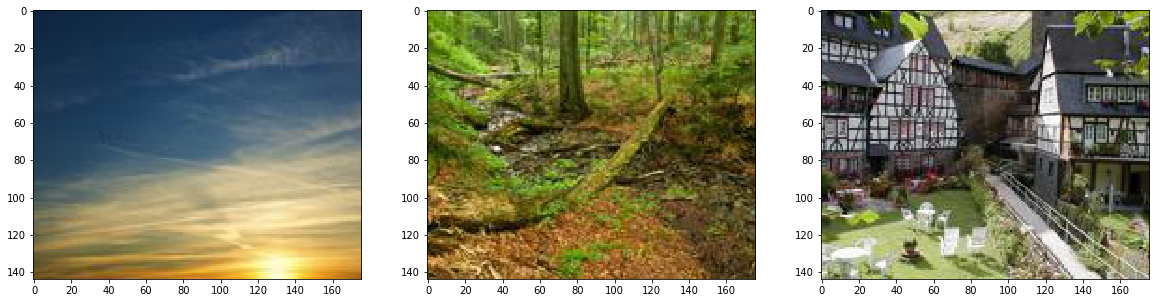

In [3]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(sunset_images[0])
ax[1].imshow(forest_images[0])
ax[2].imshow(building_images[0])
plt.show()

In [4]:
len(sunset_images), len(forest_images), len(sunset_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [5]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [6]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

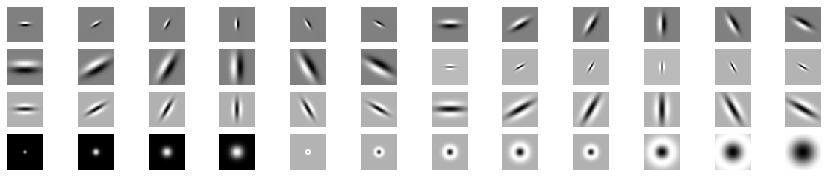

In [7]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


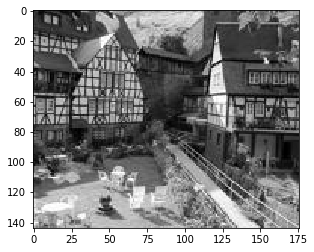

In [8]:
im = building_images[0]
im = skimage.color.rgb2gray(building_images[0])
plt.imshow(im, cmap="gray")

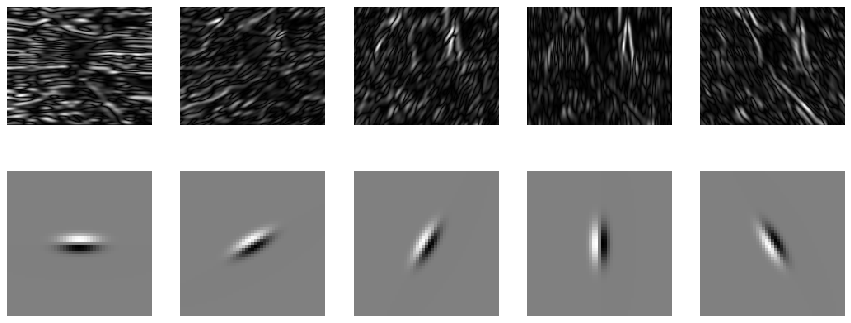

In [9]:
"""
This function convolve the given image with every filter on filter_bank 

:param im: numpy array. Must be a grayscale image, if not, our algorithm convert it
:param filter_bank: numpy array of filters. Bank of filters
:param n_filters: number of filters we want to use
"""
def visualize_features(im,  filter_bank, n_filters=5):
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))
    
    #If we want to apply more filters than the number of filters in filter_bank raise an error
    if n_filters > filter_bank.shape[-1]: raise ValueError("Number of filters exceeded")
    
    #If the image is not grayscale, we need to convert into a grayscale image
    if len(im.shape) != 2: im = skimage.color.rgb2gray(im)
        
    #In this loop we convolve the image with every filter in filter_bank and finally
    #we show the result and also the filter used in the iteration
    for n_fltr in range(n_filters):
        cur_fltr = filter_bank[:,:,n_fltr]
        im_conv = np.abs(ndimage.convolve(im, cur_fltr))
            
        ax[0][n_fltr].imshow(im_conv, cmap='gray')
        ax[1][n_fltr].imshow(cur_fltr, cmap='gray')
            
        ax[0][n_fltr].axis('off')
        ax[1][n_fltr].axis('off')
            
visualize_features(im, filter_bank)


## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [10]:
im = skimage.color.rgb2gray(building_images[0])

"""
This function returns a feature vector with the mean of the absolute value 
of the convolved images with the respective k filter

:param image: numpy array. Must be a grayscale image, if not, our algorithm convert it
:param filter_bank: numpy array of filters. Bank of filters
:param n_filters: number of filters we want to use
:return: a numpy array where every position contains the mean of the absolute value
of the k convolution
"""
def features_from_filter_bank(image, filter_bank, n_filters=filter_bank.shape[-1]):
    
    #If we want to apply more filters than the number of filters in filter_bank raise an error
    if n_filters > filter_bank.shape[-1]: raise ValueError("Number of filters exceeded")
        
    #If the image is not grayscale, we need to convert into a grayscale image
    if len(image.shape) != 2: image = skimage.color.rgb2gray(image)
    
    #Apply the mean of the absolute value on the convolution with the k filter and finally return
    features_for_im = [np.mean(np.abs(ndimage.convolve(image, filter_bank[:,:,k])))
                       for k in range(n_filters)]
    
    return np.array(features_for_im)

features_for_im = features_from_filter_bank(im, filter_bank, n_filters) # ~7s

## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [12]:
all_images = building_images + forest_images + sunset_images

In [13]:
%%time

"""
This function returns a matrix containing every feature vector (with all the filters) for every image on the
set all_images

The function apply the features_from_filter_bank algorithm to extract every feature vector

:param all_images: list of images
:param filter_bank: numpy array of filters. Bank of filters
:return: matrix with the values of every k feature vector
"""
def get_class_features(all_images,  filter_bank):
    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors = [features_from_filter_bank(img, filter_bank, n_filters) for img in all_images]

    return np.array(all_feature_vectors)

all_feature_vectors=get_class_features(all_images,  filter_bank)

CPU times: user 9min 7s, sys: 40.6 s, total: 9min 48s
Wall time: 9min 48s


## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


In [14]:
datasets = [building_images, forest_images, sunset_images]

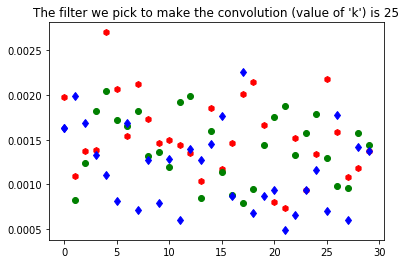

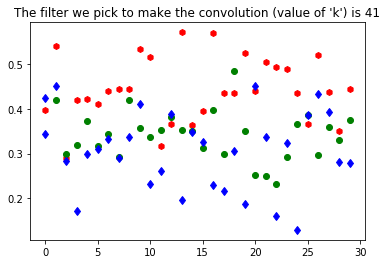

In [16]:
"""
This function display the k value on every feature vectors of every dataset.
Each dataset is diferenciated by colour and shape on the points:
    - building: red hexagons
    - forest: green circles
    - sunset: blue diamonds

:param k: index on the feature vector
:param all_feature_vectors: numpy array of arrays. Vector of all feature vectors
:return: matrix with the values of every k feature vector
"""
def visualize_features(k, all_feature_vectors):
    #In our case we only need two indexes
    building, forest = len(building_images), len(forest_images)+len(building_images)
    
    #We will being displaying all the dots progressively only changing the colour/shape
    for i in range(len(all_feature_vectors)):
        if i<building:
            color = 'rh'
        elif i>building and i<forest:
            color = 'go'
        else:
            color = 'bd'
        x = i%30
        y = all_feature_vectors[i][k]
        
        plt.plot(x,y,color)
    
    #Finally display the whole plot
    plt.title("The filter we pick to make the convolution (value of 'k') is " + str(k))
    plt.show()
    
visualize_features(25, all_feature_vectors)  
visualize_features(41, all_feature_vectors)





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar images (according to the l2 norm) and the distances from the closest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

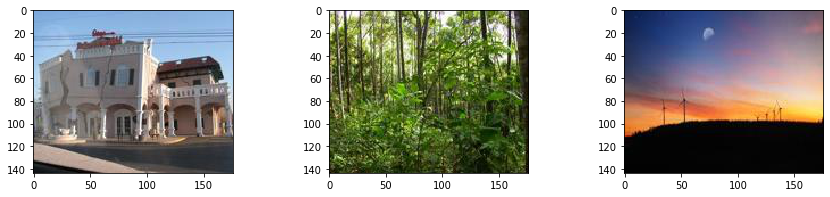

In [17]:
X = np.array(all_feature_vectors)
ind_1 = 6
ind_2 = 30
ind_3 = 65

query_1 = X[6, :]
query_2 = X[30,:]
query_3 = X[65,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[6]) 
ax[1].imshow(all_images[30])
ax[2].imshow(all_images[65])

In [53]:
"""
This function returns the top k similar images from the whole dataset respect the query one.

:param query: feature array of the query image
:param X: array of all the feature vectors
:param k: number of images similar to query
:return: list with the index of the k closest images, list with the distances of the k images respect the query one
"""
def retrieve_k_images_from_X(query, X, k):
    #Compute all the distances for all the feature vectors with the query one
    idx_sorted_images = sorted([(i, np.linalg.norm(query - X[i])) for i in range(X.shape[0])], key=lambda x: x[1])

    #Pick up the first k
    if(idx_sorted_images[0][1] == 0):
        k_closest_to_query = idx_sorted_images[1:k+1]
    else:    
        k_closest_to_query = idx_sorted_images[:k]
    
    #Unzip the dictionary and then return
    closest_images, closest_distances = list(zip(*k_closest_to_query))
    
    return closest_images, closest_distances

"""
This function display the top k images similar to query (index on the index list)

:param k: number of images we want to display
:param dataset: dataset of all the images 
:param indexes (python list type): list of the index of top k most similar images respect query
:param original_im_indx (int type): index of the image used for the retrieval
"""
def plot_retrieved_images(k, dataset, indexes, original_im_indx):
    
    #If we want to show more than we have then k to the maximum number we are able to display
    if k > len(indexes): k = len(indexes)
        
    indexes = [original_im_indx] + list(indexes) #we add to the first position the image which we actually used to retrieve the others
    
    #Finally we only have to display'em
    fig, ax = plt.subplots(ncols=k, nrows=1, figsize=(15,3))
    for i in range(k):
        ax[i].imshow(dataset[indexes[i]])
        ax[i].axis('off')
    plt.show()

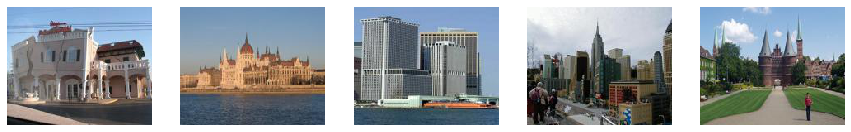

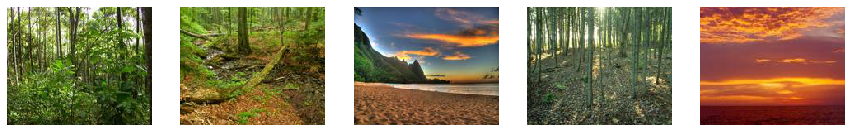

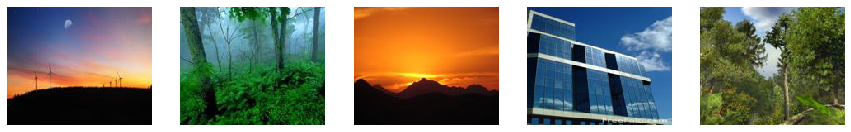

In [39]:
ind = [6,30,65]
for i in ind:
    indexes, distances = retrieve_k_images_from_X(X[i,:],X,12) #we get the the indexes and the distances
    plot_retrieved_images(5, all_images, indexes, i)

## Exercise 5.6 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.

- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?


In [41]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [42]:
"""
This function computes the accuracy of the function for image retrieval

:param X: All the feature vectors
:param class_labels: Label corresponding to the type of each 'subdataset'
:param k: number of images to retrieve
:param query: feature vector to compare with
:param class_query: Label of the query class
:return acc: float of the accuracy
"""
def accuracy(X, class_labels, k, query, class_query):
    acc = None
    total = 0
    
    images_in, distances = retrieve_k_images_from_X(query, X, k)
    
    #if distance is 0 means that is the image used for the retrieval so we ignore it
    if(distances[0]==0):
        images_in = images_in[1:]
        
    #calculate the total accurance
    for i in images_in:
        if(class_labels[i] == class_query):
            total+=1
    acc = total/k
    return acc

In [67]:
query_dict = {0:query_1, 1:query_2, 2:query_3}

for n_query in range(len(query_dict)):
    print("Accuracy for query_", str(n_query+1), " is ", accuracy(X,class_labels,4,query_dict[n_query],n_query))

Accuracy for query_ 1  is  1.0
Accuracy for query_ 2  is  0.5
Accuracy for query_ 3  is  0.25


## Exercise 5.7 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [44]:
"""
This function computes the feature vector for every channel on the rgb image.

It uses internally features_from_filter_bank.

:param image: numpy matrix rgb
:param filter_bank: bank of filters to compare with the image and obtain the features
:return: array of features with dimension n_filters*3 (in our case 144)
"""
def lm_features_rgb(image, filter_bank):

    n_filters = filter_bank.shape[-1]
    im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(3*n_filters)
    # Complete
    #we concatenate each layer feature in one vectorized array
    features_for_im[:n_filters] = features_from_filter_bank(image[:,:,0],filter_bank,n_filters)
    features_for_im[n_filters:n_filters*2] = features_from_filter_bank(image[:,:,1],filter_bank,n_filters)
    features_for_im[n_filters*2:n_filters*3] = features_from_filter_bank(image[:,:,2],filter_bank,n_filters)
    
    return features_for_im

In [45]:
%%time 
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank)

Wall time: 26.2 s



## Exercise 5.8 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [50]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [51]:
from joblib import Parallel, delayed
from tqdm import tqdm

inputs = tqdm(all_images) #this allows us monetize what's happening
n_cores = mp.cpu_count()

X_lm_rgb = Parallel(n_jobs=n_cores)(delayed(lm_features_rgb)(i,filter_bank) for i in tqdm(inputs))



100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [17:15<00:00,  9.49s/it]

## 5.9 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

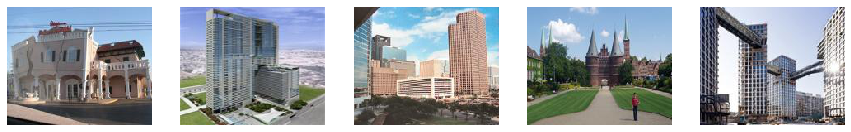

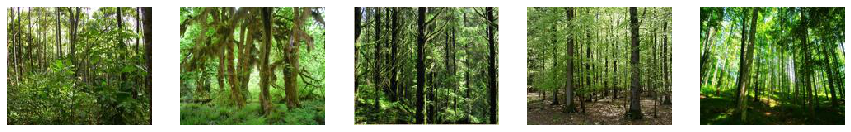

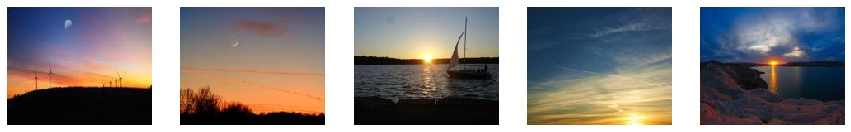

In [55]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)
ind = [ind_1,ind_2,ind_3]

#retrieve and plot the most similar the most similar images
for i in ind:
    indexes, distances = retrieve_k_images_from_X(X_lm_rgb[i,:],X_lm_rgb,12) #we get the 12 most accurate images
    plot_retrieved_images(5,all_images,indexes,i)

In [57]:
#let's find out if the accuracy is higher
ind = [ind_1,ind_2,ind_3]

for i in ind:
    print("Accuracy for image with index '", str(i), "' is ",
          accuracy(X_lm_rgb,class_labels,4,X_lm_rgb[i,:],class_labels[i]))

Accuracy for image with index ' 6 ' is  1.0
Accuracy for image with index ' 30 ' is  1.0
Accuracy for image with index ' 65 ' is  1.0


### Answer to the question

As we can see, the accuracy is higher. It means that taking in account the colors on the image, give us a lot of information. 

We must say that this method is more accurate than the previous one but it is also more expensive. We can use tools like Parallel to compute the feature vectors faster.